

# Προγραμματιστική άσκηση:
### Ταξινόμηση καρδιοτοκογραφικών σημάτων με βάση την μεταβλητότητα του καρδιακού ρυθμού


Στην ηλεκτρονική διεύθυνση: https://physionet.org/ θα βρείτε δεδομένα από καταγραφές που
έχουν συλλεχθεί για κάποιο χρονικό διάστημα πριν από τον τοκετό και ολοκληρώνονται τη
χρονική στιγμή της ολοκλήρωσης του τοκετού. Τα σήματα έχουν συλλεχθεί και δημοσιευτεί από
το Τεχνικό Πανεπιστήμιο της Πράγας και το Νοσοκομείο του Brno.

Πέρα από το <b>καρδιοτοκογραφικό σήμα (*1)</b>, μέσα στα αρχεία που έχουν αναρτηθεί, υπάρχουν και
άλλες πληροφορίες, όπως <b>το βάρος του μωρού, η ηλικία της μητέρας, το αν ο τοκετός ήταν
φυσιολογικός ή όχι, αρκετές πληροφορίες που σχετίζονται με παθογόνες καταστάσεις, αλλά και
η τιμή του pH (*2)</b>

<h3>Διαβασμα καρδιοτοκογραφικών σημάτων (*1)</h3>

In [1]:
import pandas as pd
import numpy as np  
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
"""
* Convert .dat files to .csv
* Create ann_db file for easier processing of additional annotations(2)
"""
# %run create_csv_database.py

'\n* Convert .dat files to .csv\n* Create ann_db file for easier processing of additional annotations(2)\n'

In [3]:
import pathlib
total_signals = 0
for path in pathlib.Path("./database/signals").iterdir():
    if path.is_file():
        total_signals += 1
print("Total signals:",total_signals)

Total signals: 552


In [4]:
def get_info(signal_path):
    sample_signal = pd.read_csv(signal_path).T
    return {
        'df': sample_signal,
        'df_shape': sample_signal.shape,
        'seconds': sample_signal.columns.shape[0],
        'minutes': sample_signal.columns.shape[0]/60,
        'hours': sample_signal.columns.shape[0]/3600
    }

In [5]:
first_signal_path = "database/signals/1001.csv"
sample_signal = get_info(first_signal_path)
sample_signal['df']

,0,1,2,3,4,5,6,7,8,9,...,19190,19191,19192,19193,19194,19195,19196,19197,19198,19199
seconds,0.0,1.0,2.0,3.00,4.00,5.00,6.00,7.00,8.00,9.00,...,19190.0,19191.0,19192.0,19193.0,19194.0,19195.0,19196.0,19197.0,19198.0,19199.0
FHR,150.5,150.5,151.0,151.25,151.25,150.25,150.25,150.25,148.75,148.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC,7.0,8.5,8.5,7.50,9.50,8.50,10.50,12.00,11.00,11.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Διαβασμα πρόσθετων πληροφοριών για κάθε σήμα (*2)</h3>

In [6]:
ann_db = pd.read_csv("database/ann_db.csv")
ann_db.rename(columns={'Unnamed: 0':'Labels'}, inplace=True)
ann_db = ann_db.set_index('Labels')
ann_db.index

Index(['pH', 'BDecf', 'pCO2', 'BE', 'Apgar1', 'Apgar5', 'NICU days',
       'Seizures', 'HIE', 'Intubation', 'Main diag.', 'Other diag.',
       'Gest. weeks', 'Weight(g)', 'Sex', 'Age', 'Gravidity', 'Parity',
       'Diabetes', 'Hypertension', 'Preeclampsia', 'Liq.', 'Pyrexia',
       'Meconium', 'Presentation', 'Induced', 'I.stage', 'NoProgress', 'CK/KP',
       'II.stage', 'Deliv. type', 'dbID', 'Rec. type', 'Pos. II.st.',
       'Sig2Birth'],
      dtype='object', name='Labels')

# Data Description:
#### A short (non medically exhaustive) description of the feature meaning

**analysis of umbilical artery blood sample**
- **pH** : Is the ph of the blood of the baby (n.v. 7.35-7.45). A slight increase causes blood alkalosis while a slight decrease causes acidosis. Both conditions are extremely life threatening. This value is inverse proportional to **pCO2**.
- **BDecf** : Base excess of extracellular fluid is a quantity that reflects only the non-respiratory (metabolic) component of acid-base disturbances. (Reference : [Here](https://acutecaretesting.org/en/articles/all-about-base-excess--to-be-or-not-to-be))
- **pCO2** : is the relative pressure of CO2 in the blood (n.v. 4.5-6.0Kpa). In Respiratory Acidosis, **pH** and **pCO2** are inverse proportional while in Metabolic Acidosis they are directly proportional.
- **BE** : is the excess or deficit (if negative) of bases in the blood (e.g. HCO3). The normal range is between -2 and +2 mEq/L or mmol/L. A value above the range is indicative of Metabolic Alkalosis while below the range is indicative of Metabolic Acidosis.

- **Apgar1** : It's the Apgar score at 1min from birth. It indicates the overall health status of the baby at birth. It can have values between 0 and 10 where a score above 7 is considered good. (Reference and table : [Here](https://www.birthinjurysafety.org/birth-injuries/apgar-scoring-system.html))
- **Apgar5** : It's the Apgar score at 5min from birth. See **Apgar1**.
- **Gest. weeks** : It's the number of weeks of gestation where 39-40 weeks represent a normal term delivery.
- **Weight(g)** : Is the weigth of the baby in grams at birth. This is various but in general the normal range would be between 2500g and 4500g.
- **Sex** : This is a boolean for 1 and 2 where is not clear which is male/female but shouldn't matter.
- **Age** : The Age in years of the mom.
- **Gravidity** : Is the number of times the woman has been pregnant in her life.
- **Parity** : Is the number of times the woman has been pregnant for more than 24 weeks (in a single pregnancy).
- **Diabetes** : Boolean value for Diabetes of 0 (False) and 1 (True).
- **Hypertension** : Boolean value for Hypertension of 0 (False) and 1 (True).
- **Preeclampsia** : Boolean value for Preeclampsia of 0 (False) and 1 (True). where Preeclampsia indicate a disorder of pregnancy that could lead to complications.
- **Liq.** : It referes to Liquor which in this case is the Amniotic Fluid. <mark>I'm not sure why is a boolean in the data.</mark>
- **Pyrexia** : Is a boolean value that indicate the presence of pyrexia (high temperature) in the mom or not.
- **Meconium** : Is a boolean value that indicate the presence or not of Meconium which is the earliest stool of the baby that could happen before partum.
- **Presentation** : <mark>This indicate the presentation of the baby during delivery which can be head first, legs first etc. The problem here is that this value is a number which most probably refers to an internal classification or a scale I don't know how to interpret. **See also Deliv. type**</mark>
- **Induced** : Is a boolean value that indicate if the delivery has been medically induced.
- **I.stage** : <mark>It should indicate the time in between contractions in the stage of the delivery but this is only my observational opinon based on the data.</mark>
- **NoProgress** : Is a boolean value that indicate if there has been an abort of the pregnancy or not.
- **CK/KP** : <mark>It should refer to the level of Creatine Kinase?</mark>
- **II.stage** : <mark>see **I.stage**.</mark>
- **Deliv. type** : <mark>(1: vaginal; 2: operative vaginal; 3: CS)</mark>
- **dbID** : is just an ID of the record
- **Rec. type** : <mark>No idea</mark>
- **Pos. II.st.** : <mark>No idea</mark>

In [7]:
import glob
import re

# specifying the path to csv files
path = "database/signals"
# csv files in the path
files = glob.glob(path + "/*.csv")

# defining an empty list to store content
data_frame = pd.DataFrame(columns=['Fhr','UC'])
content = []

# checking all the csv files in the specified path
for filename in files:
    name = re.sub("[^0-9]", "", filename)
    df = pd.read_csv(filename, index_col=None)
    data_frame = data_frame.append(
        {
            'tag': name,
            'Fhr': df['FHR'], 
            'UC': df['UC'],
            'labels': ann_db[name]
        },
        ignore_index=True
    )

In [8]:
data_frame.head()

,Fhr,UC,labels,tag
0,0 150.50 1 150.50 2 151.0...,0 7.0 1 8.5 2 8.5 3 ...,Labels pH 7.14 BDecf ...,1001
1,0 146.25 1 146.25 2 150.2...,0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...,1002
2,0 137.5 1 137.5 2 137.5 3...,0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.20 BDecf ...,1003
3,0 153.75 1 153.75 2 153.7...,0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...,1004
4,0 0.0 1 0.0 2 0.0 3 ...,0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.30 BDecf ...,1005


In [9]:
for index, item in data_frame.iterrows():
    print(
        data_frame.iloc[index]['labels'][
            ['I.stage',
            'II.stage',
            'Pos. II.st.'
            ]
        ]
    )
    if(index == 2): break


Labels
I.stage          232.0
II.stage          20.0
Pos. II.st.    14400.0
Name: 1001, dtype: float64
Labels
I.stage          220.0
II.stage          20.0
Pos. II.st.    14400.0
Name: 1002, dtype: float64
Labels
I.stage          215.0
II.stage          15.0
Pos. II.st.    14400.0
Name: 1003, dtype: float64


Δεν λήφθηκαν υπόψιν τα σήματα όπου αφορούσαν
περιπτώσεις καισαρικής τομής, μιας και κρίθηκε περισσότερο αξιόπιστο η μελέτη να
βασιστεί σε σήματα που προκύπτουν από φυσιολογικό τοκετό. Όπως είναι λογικό,
είναι πολύ πιθανό σε αυτά τα 46 σήματα που αφορούσαν περιπτώσεις καισαρικής
τομής, να υπήρχε ήδη διάγνωση για κάποιο παθολογικό πρόβλημα είτε στο έμβρυο
είτε στην μητέρα, συνεπώς αυτό το γεγονός θα επηρέαζε τα αποτελέσματα των
μεθόδων που εφαρμόστηκαν.

In [10]:
cesarean_records = list()
for i in range(data_frame.shape[0]):
    if (data_frame.iloc[i]['labels']['Deliv. type'] != 1.0):
        cesarean_records.append(i)
data_frame = data_frame.drop(cesarean_records)

* The maximum missing value in FHR is 53.50% and average is 18.78%. 
* We can't delete any timestamp because deleting it would change the length of each signal. 
* So instead of deletion the 0 values have been filled with rolling mean with a window of 100 previous timestamps.

In [11]:
max_missing_values_fhr = 0
avg_missing_values_fhr = 0
for index, row in data_frame.iterrows():
    missing_values_fhr = 0
    for value in row['Fhr']:
        if(value == 0):
            missing_values_fhr += 1
    if(missing_values_fhr > max_missing_values_fhr):
        max_missing_values_fhr = missing_values_fhr
    avg_missing_values_fhr += ( missing_values_fhr / 19200 )
        
print(max_missing_values_fhr / 19200, avg_missing_values_fhr / data_frame.shape[0])

0.5810416666666667 0.1632003458498022


In [12]:
noisy_thresh = 0.20
noisy_records = list()
for i in range(data_frame.shape[0]):
    record = data_frame.iloc[i]
    num_zeros = (record['Fhr'] == 0).astype(int).sum()
    perc_zeros = num_zeros / record['Fhr'].shape[0]
    if( perc_zeros > noisy_thresh ):
        noisy_records.append(i)
data_frame = data_frame.drop(noisy_records)
data_frame.shape

(296, 4)

In [15]:
data_frame.head()

,Fhr,UC,labels,tag
0,0 146.25 1 146.25 2 150.2...,0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...,1002
1,0 153.75 1 153.75 2 153.7...,0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...,1004
2,0 0.0 1 0.0 2 0.0 3 ...,0 18.0 1 19.0 2 19.5 3 ...,Labels pH 7.36 BDecf ...,1008
3,0 126.00 1 127.00 2 127.0...,0 17.0 1 19.0 2 19.0 3 ...,Labels pH 7.35 BDecf ...,1010
4,0 149.50 1 149.75 2 149.7...,0 12.0 1 11.5 2 11.5 3 ...,Labels pH 7.37 BDecf ...,1011


In [17]:
'''
Convert bpm to miliseconds
'''
data_frame['Fhr'] = (60000 / data_frame['Fhr'])
data_frame.head()

,Fhr,UC,labels,tag
0,0 146.25 1 146.25 2 150.2...,0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...,1002
1,0 153.75 1 153.75 2 153.7...,0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...,1004
2,0 0.0 1 0.0 2 0.0 3 ...,0 18.0 1 19.0 2 19.5 3 ...,Labels pH 7.36 BDecf ...,1008
3,0 126.00 1 127.00 2 127.0...,0 17.0 1 19.0 2 19.0 3 ...,Labels pH 7.35 BDecf ...,1010
4,0 149.50 1 149.75 2 149.7...,0 12.0 1 11.5 2 11.5 3 ...,Labels pH 7.37 BDecf ...,1011


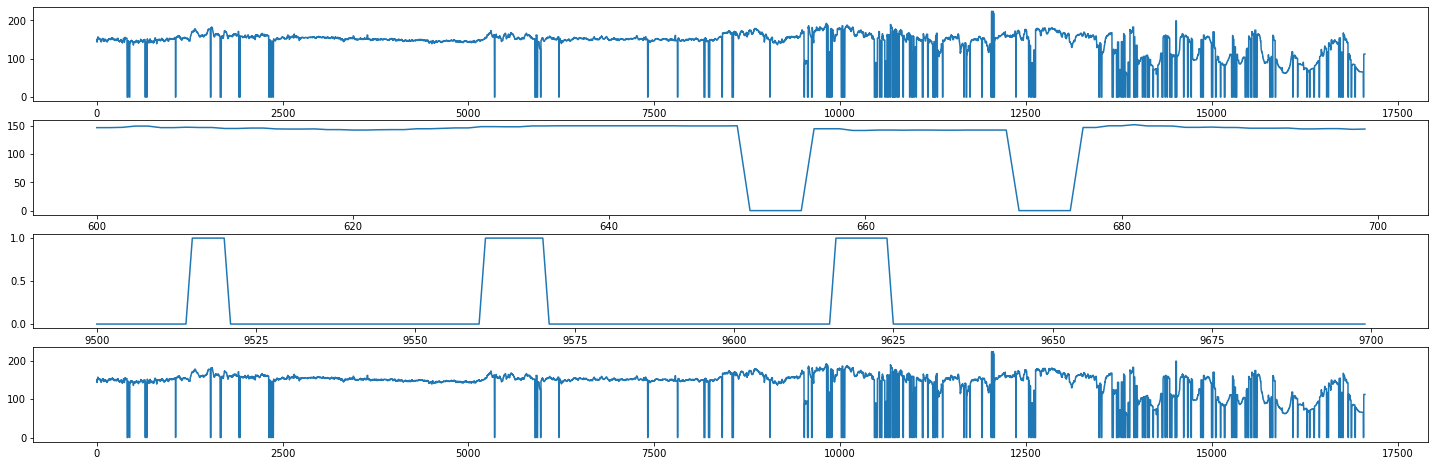

In [49]:
fig,ax = plt.subplots(4,1, figsize=(25,8))

ax[0].plot(data_frame.iloc[0]['Fhr'])
ax[1].plot(data_frame.iloc[0]['Fhr'][600:700])
ax[2].plot((data_frame.iloc[0]['Fhr'][9500:9700] == 0))
ax[3].plot(data_frame.iloc[0]['Fhr'])

In [71]:
for row_i , fhr in data_frame['Fhr'].iteritems():
    median = fhr.median()
    data_frame.iloc[row_i]['Fhr'] = fhr.mask(fhr > median * 0.25, median)
    data_frame.iloc[row_i]['Fhr'] = fhr.mask(fhr < median * 0.25, median)


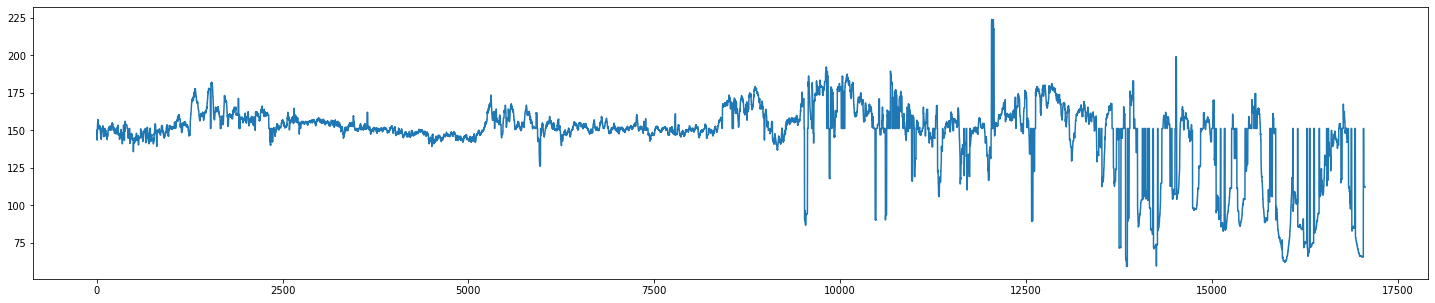

In [80]:
fig,ax = plt.subplots(1,1, figsize=(25,5))
ax.plot(data_frame.iloc[0]['Fhr'])

In [23]:
%%latex
$$ {\displaystyle y=y_{0}\left(1-{\frac {x-x_{0}}{x_{1}-x_{0}}}\right)+y_{1}\left(1-{\frac {x_{1}-x}{x_{1}-x_{0}}}\right)=y_{0}\left(1-{\frac {x-x_{0}}{x_{1}-x_{0}}}\right)+y_{1}\left({\frac {x-x_{0}}{x_{1}-x_{0}}}\right),} $$

<IPython.core.display.Latex object>